<a href="https://colab.research.google.com/github/federicOO1/LAB-IA/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import librerie


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
import os
import numpy as np
import PIL
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install rasterio
import rasterio
from rasterio.plot import reshape_as_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 51.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive/PotsdamDataset")

In [55]:
class PotsdamDataset(Dataset):
    def __init__(self, dataset_folder):
        self.dataset_folder = dataset_folder
        self.image_paths = []
        self.world_file_paths = []
        self.mask_paths = []

        # Leggi i percorsi delle immagini, dei file .tfw e delle maschere
        end_RGBIR_folder = os.listdir(dataset_folder)[0]
        end_LABELS_folder = os.listdir(dataset_folder)[1]

        RGBIR_folder = data_folder + '/' + end_RGBIR_folder
        LABELS_folder = data_folder + '/' + end_LABELS_folder

        for file_name in os.listdir(RGBIR_folder):
            if file_name.endswith('.tif'):
                image_path = os.path.join(RGBIR_folder, file_name)
                world_file_path = os.path.join(RGBIR_folder, file_name.replace('.tif', '.tfw'))

                if os.path.exists(world_file_path):
                    self.image_paths.append(image_path)
                    self.world_file_paths.append(world_file_path)


        for label_name in os.listdir(LABELS_folder):
            mask_path = os.path.join(LABELS_folder, label_name)

            if os.path.exists(mask_path):
              self.mask_paths.append(mask_path)
        self.image_paths.sort()
        self.world_file_paths.sort()
        self.mask_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def get_image_paths(self, indices):
        return [self.image_paths[idx] for idx in indices]

    def get_mask_paths(self, indices):
        return [self.mask_paths[idx] for idx in indices]

    def load_world_file(self, world_file_path):
          lines = open(world_file_path).readlines()
          try:
              parameters = [float(line.strip()) for line in lines if line.strip()]
              if len(parameters) == 6:
                  return parameters
              else:
                  raise ValueError("Il file .tfw non contiene 6 parametri.")
          except Exception as e:
              print(f"Errore durante la lettura dei parametri di georeferenziazione: {str(e)}")
              return None

    def convert_labels_to_tensor(self, rgb_label):
      #print("Current rgb_label:",rgb_label)
      # Definisci i colori delle classi nella maschera RGB
      colors_to_labels = {
          (255, 255, 255): 0,  # Impervious surfaces -> Classe 0
          (0, 0, 255): 1,  # Building -> Classe 1
          (0, 255, 255): 2,  # Low vegetation -> Classe 2
          (0, 255, 0): 3,  # Tree -> Classe 3
          (255, 255, 0): 4,  # Car -> Classe 4
          (255, 0, 0): 5  # Clutter/background -> Classe 5
      }
      color_image = np.array(rgb_label)

      # Rappresenta color_array come un array (6, 3)
      color_array = np.array(list(colors_to_labels.keys()),dtype=np.uint8)

      # Reshape l'immagine per renderla compatibile con l'operazione di broadcasting
      color_image_reshaped = color_image.reshape(-1, 3)

      # Calcola le differenze tra i colori nella maschera RGB e i colori delle classi
      color_diffs = np.sum(np.abs(color_image_reshaped[:, None, :] - color_array[None, :, :]), axis=-1)

      # Trova l'indice del colore più vicino per ciascun pixel
      closest_color_indices = np.argmin(color_diffs, axis=-1)

      # Mappa gli indici di colore ai valori delle classi
      class_label = np.where(np.min(color_diffs, axis=-1) == 0, closest_color_indices, -1)

      # Reshape per tornare alle dimensioni dell'immagine originale
      class_label = class_label.reshape(rgb_label.shape[1], rgb_label.shape[2])

      # Crea il tensore delle etichette di classe
      class_label_tensor = torch.tensor(class_label, dtype=torch.long)

      return class_label_tensor

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        world_file_path = self.world_file_paths[idx]
        mask_path = self.mask_paths[idx]

        # Carica l'immagine TIFF utilizzando la libreria rasterio
        image = rasterio.open(image_path).read()

        # Carica i parametri di georeferenziazione dal file .tfw
        world_params = self.load_world_file(world_file_path)

        # Carica la maschera con rasterio
        mask = rasterio.open(mask_path).read()

        # Converti la maschera RGB nel formato appropriato per CrossEntropyLoss
        label = self.convert_labels_to_tensor(mask)

        # Restituisci l'immagine, la maschera e i parametri di georeferenziazione
        return image, label, world_params


In [68]:
# Definisci il percorso della cartella contenente i dati .tif e .tfw
data_folder = "/content/drive/MyDrive/PotsdamDataset"

# Crea un'istanza del dataset
dataset = PotsdamDataset(data_folder)

size = len(dataset)
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = int(size - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
warnings.filterwarnings('ignore')
sum_values = torch.zeros(3)  # 3 canali per le immagini RGB
sum_squares = torch.zeros(3)

# Conta il numero totale di pixel nel train set
total_pixels = 0

# Itera attraverso il train_loader per accumulare i valori dei pixel
for batch in enumerate(train_loader):
    batch_idx, data_list = batch
    images_batch = [sample[0] for sample in data_list]  # Estrai le immagini dal batch
    print(images_batch)

[tensor([[[ 59,  59,  59,  ...,  43,  45,  45],
         [ 58,  60,  64,  ...,  39,  41,  43],
         [ 58,  59,  61,  ...,  39,  38,  42],
         ...,
         [ 68,  70,  73,  ...,  68,  69,  69],
         [ 56,  57,  57,  ...,  69,  68,  68],
         [ 63,  65,  66,  ...,  69,  68,  69]],

        [[ 67,  68,  69,  ...,  55,  57,  57],
         [ 65,  70,  74,  ...,  48,  51,  53],
         [ 65,  69,  72,  ...,  48,  47,  52],
         ...,
         [ 71,  73,  78,  ...,  74,  75,  75],
         [ 58,  58,  57,  ...,  74,  73,  74],
         [ 66,  67,  66,  ...,  74,  72,  75]],

        [[ 58,  59,  60,  ...,  57,  59,  59],
         [ 58,  64,  68,  ...,  51,  54,  57],
         [ 57,  62,  65,  ...,  51,  51,  56],
         ...,
         [ 62,  66,  71,  ...,  69,  71,  71],
         [ 55,  54,  54,  ...,  69,  69,  69],
         [ 60,  62,  61,  ...,  70,  67,  70]],

        [[107, 106, 106,  ...,  42,  43,  42],
         [105, 108, 111,  ...,  38,  40,  41],
         [1

KeyboardInterrupt: ignored

In [82]:
warnings.filterwarnings('ignore')
sum_values = torch.zeros(3)  # 3 canali per le immagini RGB
sum_squares = torch.zeros(3)

# Conta il numero totale di pixel nel train set
total_pixels = 0

# Itera attraverso il train_loader per accumulare i valori dei pixel
for batch in enumerate(train_loader):
    batch_idx, data_list = batch
    images_batch = [sample[0] for sample in data_list]  # Estrai le immagini dal batch

    for image in images_batch:
        num_channels, height, width = image.size(0), image.size(1), image.size(2)
        total_pixels += num_channels * height * width

        # Somma i valori dei pixel per ciascun canale
        sum_values += torch.sum(image, dim=(1, 2))
        sum_squares += torch.sum(image ** 2, dim=(1, 2))

# Calcola la media e la deviazione standard
mean_values = sum_values / total_pixels
std_dev_values = torch.sqrt((sum_squares / total_pixels) - (mean_values ** 2))

print("Media per canale:", mean_values)
print("Deviazione standard per canale:", std_dev_values)



RuntimeError: ignored

In [61]:
train_mask_paths

['/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_6_11_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_2_14_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_5_10_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_7_11_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_7_10_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_2_13_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_6_7_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_3_13_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_4_13_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_3_10_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_6_8_label.tif',
 '/content/drive/MyDrive/PotsdamDataset/5_Labels_all/top_potsdam_7_7_label.tif',
 '/content/drive/My

In [12]:
rgb_label = rasterio.open(dataset.mask_paths[30]).read()
color_image_2 = reshape_as_image(rgb_label)
# Definisci i colori delle classi nella maschera RGB
#print(color_image_2)

# Inizializza un'immagine di etichette con valori di sfondo (0)
height, width, _ = color_image_2.shape
print(height, width, _)
class_label_2 = np.zeros((height, width), dtype=np.int32)

for i in range(height):
    for j in range(width):
        pixel_color = tuple(color_image_2[i, j])
        #print(pixel_color)
        class_label_2[i, j] = colors_to_labels.get(pixel_color, -1)  # -1 per i colori non mappati
        #print(class_label_2[i, j])


# Stampa l'array di classi risultante
class_label_2_tensor = torch.tensor(class_label_2, dtype=torch.long)

6000 6000 3


In [32]:
height, width = label.shape
rgb_label_2 = np.zeros((height, width, 3), dtype=np.uint8)

# Inverti la mappa delle classi (da classi a colori)
class_rgb_color = {
    0: (255, 255, 255),  # Impervious surfaces
    1: (0, 0, 255),       # Building
    2: (0, 255, 255),     # Low vegetation
    3: (0, 255, 0),       # Tree
    4: (255, 255, 0),     # Car
    5: (255, 0, 0)        # Clutter/background
}

for i in range(height):
    for j in range(width):
        class_index = label[i, j]
        if class_index in class_rgb_color:
            # Assegna il colore corrispondente alla classe
            rgb_label_2[i, j] = class_rgb_color[class_index]
        else:
            # Se la classe non è mappata, assegna un colore di fallback (nero)
            rgb_label_2[i, j] = (0, 0, 0)

KeyboardInterrupt: ignored

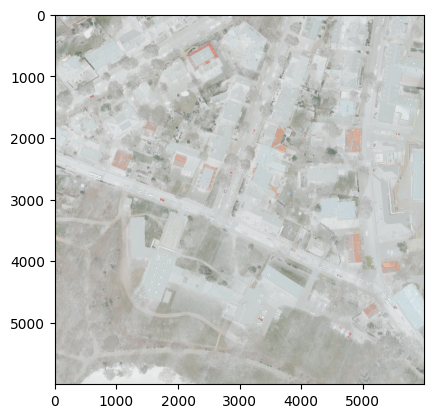